## CS 6120: Natural Language Processing

### 
### 

You will be dealing with movie review data that includes both positive and negative reviews in this assignment. You will use Sentiment Analysis to assess if a given review is positive or negative using the provided dataset.

Therefore, we will make use of Naive Bayes algorithm to perform sentiment analysis on the movie review dataset.

## Importing the Libraries

# Submitted By: Ataish Nehra

In [1]:
import numpy as np
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\ATAISH
[nltk_data]     NEHRA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\ATAISH
[nltk_data]     NEHRA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\ATAISH
[nltk_data]     NEHRA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Reading the data

When reading the data, ensure that the '.csv' file is in the same location where your jupyter notebook is used. This way the files are organized and easy to read using the pandas library. 

In [2]:
## Reading the data and removing columns that are not important. 
df = pd.read_csv("movie_reviews.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [3]:
# print head of data frame with help of head function

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


## Count plot of the output categories: positive or negative

Feel free to take a look at the output and whether the classes are balanced or imbalanced. 

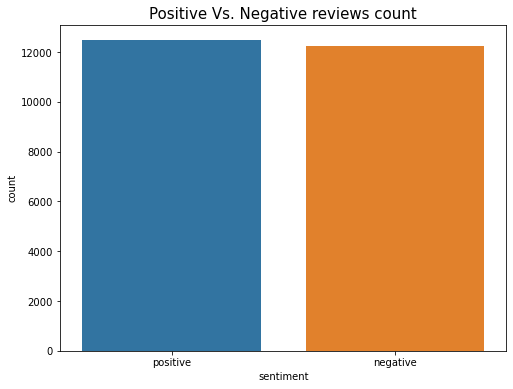

In [5]:
plt.figure(figsize = (8,6))
sns.countplot(data=df,x='sentiment')
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()


## Upsampling the minority class: (5 points)

It is known that Naive bayes is not robust to class imbalance. It could be seen above that the data is little imbalanced. Therefore, class balancing can be done before giving it to the Naive Bayes model for prediction. 

Feel free to use 'resample' library from sklearn. 

In [6]:
## hint: use resample from sklearn.utils
from sklearn.utils import resample

df_majority = df[df.sentiment == "positive"]
df_minority = df[df.sentiment == "negative"]

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([df_majority, negative_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1, random_state=0)

In [7]:
## Just to ensure that upsampling was done successfully, take a look at the shape of the data in 
## this cell. 

# print the shape of data set with the help of shape function having "negative" as class label
print(negative_upsample.shape)

(12474, 2)


### Expected Output : 
(12474, 2)

In [8]:
## Ensure that the same number of data points are present for both 'positive' and 'negative' data

# print the shape of data set with the help of shape function having "positive" as class label
print(df_majority.shape)

(12474, 2)


### Expected Output : 
(12474, 2)

In [9]:
## In this cell, we are going to be dividing the data into train and test points
## Ensure that you store the upsampled data in a variable called 'df_upsampled' 
## so that the below operations are performed successfully


## Considering 10000 positive and 10000 negative data points

negative_data_points_train = df_upsampled[df_upsampled["sentiment"] == "negative"].iloc[:10000]
positive_data_points_train = df_upsampled[df_upsampled["sentiment"] == "positive"].iloc[:10000]


## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled["sentiment"] == "negative"].iloc[10000:]
positive_data_points_test = df_upsampled[df_upsampled["sentiment"] == "positive"].iloc[10000:]



## Concatenate the training positive and negative reviews
X_train = pd.concat([negative_data_points_train["review"], positive_data_points_train["review"]])

# Concatenating the training positive and negative outputs
y_train = pd.concat([negative_data_points_train["sentiment"], positive_data_points_train["sentiment"]])

# Concatenating the test positive and negative reviews
X_test = pd.concat([negative_data_points_test["review"], positive_data_points_test["review"]])

# Concatenating the test positive and negative outputs
y_test = pd.concat([negative_data_points_test["sentiment"], positive_data_points_test["sentiment"]])

In [10]:
## Take a look at the total number of classes and their count using '.value_counts()' for y_train and y_test.
## Ensure that there are equal number of positive and negative reviews. 

print(y_train.value_counts())

negative    10000
positive    10000
Name: sentiment, dtype: int64


### Expected Output:
negative    10000<br>
positive    10000<br>
Name: sentiment, dtype: int64

In [11]:

print(y_test.value_counts())

negative    2474
positive    2474
Name: sentiment, dtype: int64


### Expected Output : 
negative    2474<br>
positive    2474<br>
Name: sentiment, dtype: int64

## Q1. Pre-process the reviews: (10 points)

We know that a review contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction. 

In the cell below, one must implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words. 

In addition to this, perform stemming operation so that similar words are reduced. To know more about stemming, feel free to take a look at this link.

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [12]:
# TASK CELL
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

def clean_review(review):
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review. 
    '''

    
    review = re.sub(r'https?:\/\/\S+|www\.\S+', '', review) #We are using regular expressions to remove links.
    review = re.sub(r'[^\w\s]', '', review) #We are using regular expressions to remove punctuations.
    review = review.lower() #We are using regular expressions to convert to lowercase.
    Cleaned1 = word_tokenize(review)


    #We will remove the stop words in the below portion of the code.
    stop_words = set(stopwords.words('english'))
    Cleaned2 = []
    for word in Cleaned1:
      if word.lower() not in stop_words:
        Cleaned2.append(word.lower())
    

    
    #Stemming is done in the below part
    ps = PorterStemmer()
    Cleaned3 = []
    for word in Cleaned2:
      Cleaned3.append(ps.stem(word))
    
    #Lemmatisation is implemented below using WordNetlemmatizer.
    lemmatizer = WordNetLemmatizer()
    Cleaned4 = list(map(lemmatizer.lemmatize, Cleaned2))

    return Cleaned4

In [13]:
#Checking if the preprocessing is able to identify the words.
clean_review(X_train.iloc[0])

['warning',
 'review',
 'contains',
 'slight',
 'spoilersbr',
 'br',
 'there',
 'parallel',
 'universe',
 'gone',
 '60',
 'second',
 'dark',
 'edgy',
 'controversial',
 'independent',
 'movie',
 'unfortunately',
 'dimension',
 'gone',
 'flashy',
 'vacuous',
 'testosteronefuelled',
 'moronfest',
 'starring',
 'nicolas',
 'cagebr',
 'br',
 'reason',
 'really',
 'worth',
 'getting',
 'large',
 'number',
 'crony',
 'four',
 'day',
 'steal',
 'fifty',
 'expensive',
 'car',
 'one',
 'alarm',
 'crew',
 'consists',
 'guy',
 'funnyshaped',
 'ear',
 'who',
 'rumoured',
 'new',
 'superman',
 'guy',
 'conducted',
 'electricity',
 'xfiles',
 'exprofessional',
 'footballer',
 'two',
 'token',
 'black',
 'menbr',
 'br',
 'enemy',
 'cop',
 'rival',
 'car',
 'thief',
 'bilborough',
 'cracker',
 'manchester',
 'accent',
 'suitably',
 'flattened',
 'broadened',
 'american',
 'audience',
 'used',
 'sort',
 'thing',
 'since',
 'daphne',
 'frasier',
 'there',
 'also',
 'angelina',
 'jolie',
 'get',
 'charac

## Q2. Implement a find_occurrence function (5 points):

In this function, we find the total occurrence of a word giving information such as label, word and frequency dictionary.

Note that this function is used later in the code when we are going to be predicting the output using Naive Bayes. 

In [14]:
# TASK CELL
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (word, label)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
    if (word, label) in frequency:
      return frequency[(word,label)]
      
    return 0


### Converting output to numerical format:

We have outputs as 'positive' or 'negative'. In the cell below, we convert it to a numerical format. 

In [15]:
## With the use of mapping function, we replace
## the label in the form of string to an integer.
output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

For the above code: In the testing and training dataset we will convert the output to numerical format.

In [16]:
## Ensuring that there are equal number of classes on the training data. 
y_train.value_counts()

1    10000
0    10000
Name: sentiment, dtype: int64

In [17]:
## Choosing a random review and taking a look at it.
X_train.iloc[0]

'WARNING: REVIEW CONTAINS SLIGHT SPOILERS<br /><br />There\'s a parallel universe out there where Gone In 60 Seconds is a dark, edgy, controversial independent movie. Unfortunately in this dimension Gone... is a flashy, vacuous, testosterone-fuelled moronfest starring Nicolas Cage.<br /><br />For reasons not really worth getting into, he and his large number of cronies have four days to steal fifty expensive cars, only one of which has an alarm. This crew consists of the guy with the funny-shaped ears who\'s rumoured to be the new Superman; a guy who conducted electricity in The X-Files; an ex-professional footballer and two token black men.<br /><br />Their enemies are cops, rival car thieves and Bilborough from Cracker, his Manchester accent suitably flattened and broadened for American audiences who are now used to that sort of thing since Daphne in Frasier. There\'s also Angelina Jolie, who gets no character; save to be a receptacle to men\'s sexual desires. She and Cage are suppos

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text. 

Therefore, those words would be removed. It also reduces the computation time. 

Therefore, it is a good practice we are following.

In [18]:
custom_review = X_train.iloc[0]

# print cleaned review
print(clean_review(custom_review))

['warning', 'review', 'contains', 'slight', 'spoilersbr', 'br', 'there', 'parallel', 'universe', 'gone', '60', 'second', 'dark', 'edgy', 'controversial', 'independent', 'movie', 'unfortunately', 'dimension', 'gone', 'flashy', 'vacuous', 'testosteronefuelled', 'moronfest', 'starring', 'nicolas', 'cagebr', 'br', 'reason', 'really', 'worth', 'getting', 'large', 'number', 'crony', 'four', 'day', 'steal', 'fifty', 'expensive', 'car', 'one', 'alarm', 'crew', 'consists', 'guy', 'funnyshaped', 'ear', 'who', 'rumoured', 'new', 'superman', 'guy', 'conducted', 'electricity', 'xfiles', 'exprofessional', 'footballer', 'two', 'token', 'black', 'menbr', 'br', 'enemy', 'cop', 'rival', 'car', 'thief', 'bilborough', 'cracker', 'manchester', 'accent', 'suitably', 'flattened', 'broadened', 'american', 'audience', 'used', 'sort', 'thing', 'since', 'daphne', 'frasier', 'there', 'also', 'angelina', 'jolie', 'get', 'character', 'save', 'receptacle', 'men', 'sexual', 'desire', 'cage', 'supposed', 'old', 'flame

We now use this function to pre-process the review and remove words that don't add a lot of meaning in our model. 

## Q3. Implementing review counter function: (5 points)

It is now time to implement the count function for the reviews. 

In this function, we count the occurrence of words and get the probabilities 
for the words based on the training data. 

In other words, we get the probability of occurrence of a word, given that the output is 'positive'.

Similarly, we also compute the probability of occurence of a word, given that the output is 'negative'.



In [19]:
def review_counter(output_occurrence, reviews, positive_or_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1
    
    for label, review in zip(positive_or_negative, reviews):
        split_review = clean_review(review)
        for word in split_review:
            key = (word, label)
            if key in output_occurrence:
                output_occurrence[key] += 1
            else:
                output_occurrence[key] = 1
    return output_occurrence



### Test your function with example reviews:

Feel free to run the cell below and understand whether the above function that you have defined is producing the optimum results. 

In [20]:
# Testing your function

result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter(result,reviews, ys)

{('got', 1): 1,
 ('bored', 1): 2,
 ('throught', 1): 1,
 ('moview', 1): 1,
 ('movie', 0): 2,
 ('fantastic', 0): 1,
 ('watch', 1): 1,
 ('complete', 1): 1,
 ('waste', 1): 1,
 ('time', 1): 1,
 ('money', 1): 1,
 ('enjoyed', 0): 1,
 ('fullest', 0): 1}

### Expected Output:
 {('bored', 1): 2, <br>
 ('complete', 1): 1, <br>
 ('enjoyed', 0): 1, <br>
 ('fantastic', 0): 1, <br>
 ('fullest', 0): 1, <br>
 ('got', 1): 1, <br>
 ('money', 1): 1, <br>
 ('movie', 0): 2, <br>
 ('moview', 1): 1, <br>
 ('throught', 1): 1, <br>
 ('time', 1): 1, <br>
 ('waste', 1): 1, <br>
 ('watch', 1): 1}

In [21]:
# Build the freqs dictionary for later uses

freqs = review_counter({}, X_train, y_train)

In [22]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels. 
## In this, we are computing the frequency of occurrence of word given that a review is 'positive'.
## Similarly, we also compute the frequence of occurence of word given that a review is 'negative'.
freqs

{('warning', 1): 163,
 ('review', 1): 726,
 ('contains', 1): 140,
 ('slight', 1): 55,
 ('spoilersbr', 1): 58,
 ('br', 1): 23386,
 ('there', 1): 1367,
 ('parallel', 1): 42,
 ('universe', 1): 56,
 ('gone', 1): 325,
 ('60', 1): 149,
 ('second', 1): 869,
 ('dark', 1): 504,
 ('edgy', 1): 35,
 ('controversial', 1): 40,
 ('independent', 1): 90,
 ('movie', 1): 22107,
 ('unfortunately', 1): 718,
 ('dimension', 1): 37,
 ('flashy', 1): 16,
 ('vacuous', 1): 11,
 ('testosteronefuelled', 1): 2,
 ('moronfest', 1): 2,
 ('starring', 1): 157,
 ('nicolas', 1): 16,
 ('cagebr', 1): 4,
 ('reason', 1): 1381,
 ('really', 1): 4919,
 ('worth', 1): 853,
 ('getting', 1): 729,
 ('large', 1): 211,
 ('number', 1): 421,
 ('crony', 1): 6,
 ('four', 1): 330,
 ('day', 1): 1300,
 ('steal', 1): 191,
 ('fifty', 1): 58,
 ('expensive', 1): 45,
 ('car', 1): 721,
 ('one', 1): 10299,
 ('alarm', 1): 22,
 ('crew', 1): 289,
 ('consists', 1): 88,
 ('guy', 1): 2137,
 ('funnyshaped', 1): 2,
 ('ear', 1): 81,
 ('who', 1): 248,
 ('rumou

## Q4. Training the Naive Bayes Model: (20 points)

Now we are in the training phase of the Naive Bayes algorithm. In this cell, take a look at the ways to calculate the log likelihood and log prior values as these are important for testing in the next few cells. 

Also calculate the frequency of occurrence of words where the output is negative. In the same way, calculate the word frequency count using the above functions in order to compute the log likelihood.

Return the logprior and loglikelihood output by the model from this function. 

In [23]:
len(freqs)

121693

In [24]:
from numpy.ma.core import log
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    unique =set()
    keys = freqs.keys()
    for (word,label) in keys:
      unique.add(word)
    vocab = unique
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:

            # Increment the number of positive words by the count for this (word, label) pair
            num_neg += 1 

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            num_pos += 1

    # Calculate num_doc, the number of documents
    num_doc = len(train_y)

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = y_train.value_counts()[0]

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = y_train.value_counts()[1]

    # Calculate logprior
    logprior = log(neg_num_docs)-log(pos_num_docs)

    # For each word in the vocabulary...
    
    for word in vocab:
        # get the positive and negative frequency of the word
        if (word,1) in freqs:
          freq_neg = freqs[(word,1)]
        else:
          freq_neg = 0
        if (word,0) in freqs:
          freq_pos = freqs[(word,0)]
        else:
          freq_pos = 0

        # calculate the probability that each word is positive, and negative
        p_w_neg = (freq_neg + 1)/(num_neg + V)
        p_w_pos = (freq_pos + 1)/(num_pos + V)


        # calculate the log likelihood of the word
        loglikelihood[word] = log(p_w_neg/p_w_pos) 
        
    #print(max)

    return logprior, loglikelihood

In [25]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
91691


### Expected Output 

0.0 <br>
91425

## Q5. Implementing Naive Bayes Predict Function: (10 points)

It is now time to make our prediction as to whether a given review is negative or positive respectively. 

After adding the log likelihood values, ensure that the output is 1 (negative) if the sum of the log likelihood value is greater than 0 and 0 (positive) if the sum of the log likelihood is less than or equal to 0. 

In [26]:
# TASK 4 CELL

def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''
    
    # First step is to get a list of words from the review we are supposed to be testing.
    word_l = clean_review(review)

    #Secondly we will initialise the probability to zero.
    total_prob = 0

    #We will now add the value of logprior to the initialised total probability.
    total_prob = logprior

    for word in word_l:

        #check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            total_prob += loglikelihood[word]
            #print("probability of",word,"is:",loglikelihood[word])
    
    if total_prob > 0:
        return 1
    else:
        return 0

In [27]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own review.
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1


### Expected Output :
The expected output is 1

## Q6. Implementing Naive Bayes Test function: (10 points)

In this function, implement the previous functions such as naive_bayes_predict to get the predictions for the test set. 

In addition to this, the function should return the total number of reviews that it correctly classified as 'positive' or 'negative'. 

In [28]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0  

    
    y_hats = []
    
    for review in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(review,logprior,loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)
        
        
        

    # error is the average of the absolute values of the differences between y_hats and test_y
    sum_error = 0
    accurate_count = 0
    n = len(test_y)
    for i in range(n):
      
      difference = abs(y_hats[i]-test_y.iloc[i])
      
      sum_error += difference
      if difference == 0 :
        accurate_count+=1
      

    

    
    error = sum_error / n

    accuracy = accurate_count / n


    return accuracy, y_hats

In [29]:
# For grading purpose only
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Run this cell to test your function

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


### Expected Output :

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00<br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00



In [30]:
# Feel free to check the sentiment of your own review below
my_review = 'The moview was very boring, I wanted to leave in the middle'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

### Expected Output :
1

# Q7. Evaluate the accuracy (10 Points)
1. Split your data into training and test sets using random selection. Set the seed as parameter of the function so that user can select a different training and test set by changin seed.

2. Calculate model paramters with training set.

3. Print confusion matrix for training and test set.

4. Examine False Positive and False Negative cases and provide reasoning why they get misclassified.

### Part 1: Splitting data into training and testing sets. Setting a seed as well.

In [31]:
#The code defines a function train_test that takes two arrays a and b and splits them into training and test sets 
#using the train_test_split function from scikit-learn's model_selection module. 
#The function has default parameters test_size=0.33 and seed=1.

#The returned training and test sets are then assigned to a_tr, a_tst, b_tr, and b_tst respectively. 
#In this case, the inputs df_upsampled['review'] and df_upsampled['sentiment'] are passed to the train_test function.
from sklearn.model_selection import train_test_split

def train_test(a, b, test_size=0.33, seed=1):
    return train_test_split(a, b, test_size=test_size, random_state=seed)

a_tr, a_tst, b_tr, b_tst = train_test(df_upsampled['review'], df_upsampled['sentiment'])

In [32]:
b_tr.value_counts()

positive    8367
negative    8348
Name: sentiment, dtype: int64

In [33]:
b_tst.value_counts()

negative    4126
positive    4107
Name: sentiment, dtype: int64

### Part 2: Calculate the model parameters.

In [34]:
b_tr = b_tr.map(output_map)
b_tst = b_tst.map(output_map)

freq = review_counter({}, a_tr, b_tr)
logpr, loglikeli = train_naive_bayes(freq, a_tr, b_tr)


In [35]:
# Accuracy for train and test data

accu_tr, preds_tr = test_naive_bayes(a_tr, b_tr, logpr, loglikeli)
accu_tst, preds_tst = test_naive_bayes(a_tst, b_tst, logpr, loglikeli)

In [36]:
print("Train accuracy:", accu_tr)
print("Test accuracy:" , accu_tst)

Train accuracy: 0.8941070894406222
Test accuracy: 0.8203570994777116


### Part 3: Confusion Matrix for train and test data sets.

In [37]:
from sklearn.metrics import confusion_matrix
cf_tr = confusion_matrix(b_tr, preds_tr)
cf_tst = confusion_matrix(b_tst, preds_tst)
print("Train: \n", cf_tr)
print("Test: \n", cf_tst)

Train: 
 [[6658 1709]
 [  61 8287]]
Test: 
 [[2735 1372]
 [ 107 4019]]


### Part 4:

A false positive is an outcome where the model incorrectly predicts the positive class and an outcome where a model incorrectly predicts the negative class is called a false negative.

Example of False positive: 
A patient may be diagnosed with a disease when they actually do not have a disease.

Example of False negative:
A test may show that a patient does not have a particular disease when they actually do, this type of outcome is called false negative.

The Naive Bayes technique has limited applicability in real-world use situations since it presumes that all predictors (or attributes) are independent, which is a rare occurrence in reality.

In our sentiment analyzer, it is assumed that each word is independent of the context of the entire phrase. As a result, the classifier does not grasp the context of the entire sentence and instead classifies according to the probabilities of the individual words. Sarcasm would also be misunderstood, and these characteristics increase the number of false positives and negatives.

The independence assumption of Naive Bayes makes it a fast and simple algorithm, but it also means that it has limited accuracy for more complex real-world problems. This can lead to a high rate of false positives and negatives, particularly in cases where the context of the sentence is important, as you mentioned with sarcasm and other nuances in language. Despite these limitations, Naive Bayes can still be useful in certain applications where the independence assumption is reasonable, or as a quick-and-dirty baseline for comparison with more complex algorithms.

False positive and false negative can occur in Naive Bayes Sentiment Analysis of movie reviews due to various reasons such as:

The following causes can lead to a false positive:

1. Limited training data: The model might not be able to effectively capture the subtleties of language and sentiment if it is trained on a tiny dataset.
2. Irrelevant features: The model may give more weight to irrelevant features, which could result in inaccurate classifications.
3. Unbalanced data: The model may be biased toward the majority class and produce misleading positive predictions if the dataset includes an unbalanced distribution of positive and negative ratings.

The following factors can lead to a false negative:

1. Ambiguous words: The algorithm may misread the sentiment and produce erroneous negative predictions if a review contains ambiguous words that can be read in a number of different ways.
2. Negation words: The model may not accurately identify the sentiment in a review if it contains negation words like "not" or "never," which will lead to false negatives.
3. Complex language patterns: The algorithm may have trouble capturing the sentiment in a review with complex sentence structures, which could lead to erroneous negative predictions.
4. These problems can be resolved by utilizing more sophisticated algorithms, expanding the training dataset, and optimizing the model's parameters to increase accuracy.

# Q8. Modularize your calssifier (10 points)
1. Convert your code into a python module text_classifier.py

2. The user should be able to launch the application on command prompt using python test_classifier.py command. The module will automatically load the model paramters from a local file of your choice and be ready to take the input from user on command prompt. The program will preprocess user input, tokenize and predict the class.

3. Your module will take the input from user and output sentiment class in an indefinite loop. The output should printout the probabilities for each input token along with the final classification decision. Program will quit if user enters X.


In [38]:
# We will write "logprior" and "loglikelihood" into a file called values, this file will get 
# created and saved locally on the jupyter notebook and we then downloaded that file so that it can be used later.
file1 = open("values.txt","w+")

#writing logprior in values file
file1.write(str(logprior))
file1.write("\n")

#writing loglikelihood in values file
file1.write(str(loglikelihood))
file1.close()

### Screenshot of working application with code and performed analysis is given below. 

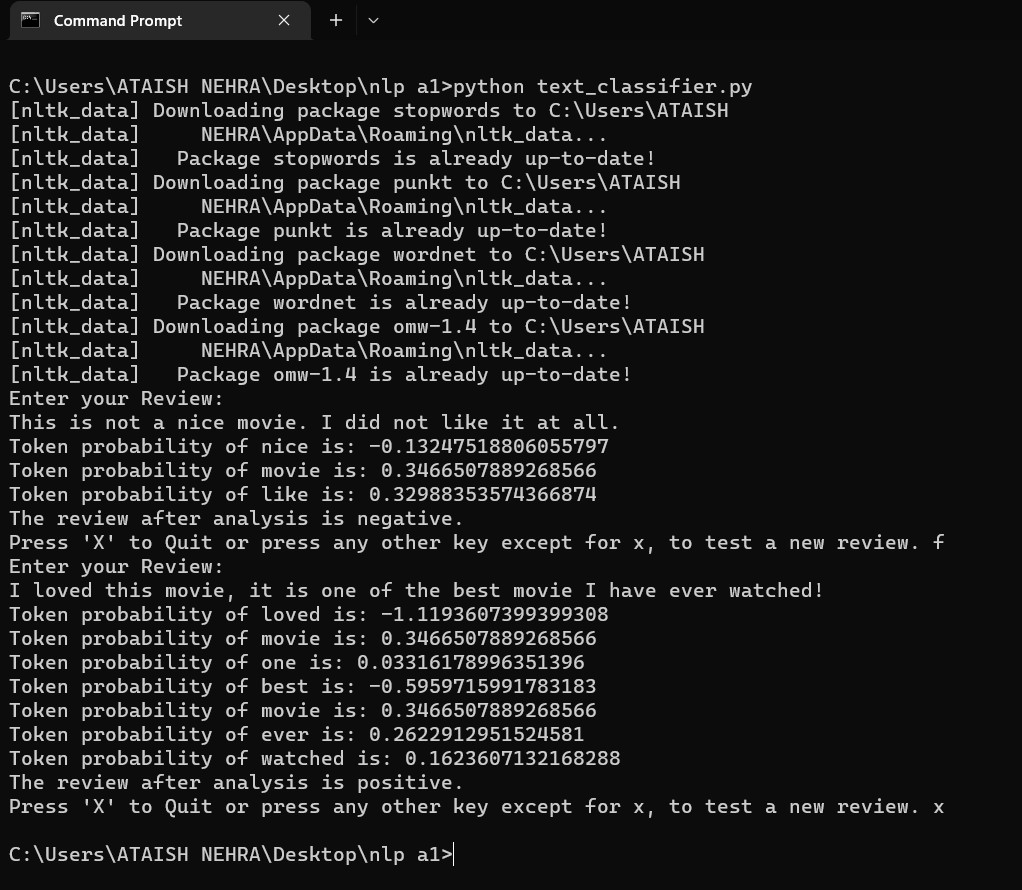

We can now just use text_classifier.py file using the values file and the above application would run smoothly.

# Q9. Theory Questions: (10 points)

1. Why is Laplace Smoothing or Additive Smoothing required while executing Naive Bayes operations, especially for text classification? Show how not having additive smoothing leads to bad outcomes by using an example of training and the test set. (10 points)


2. Why are logarithmic values computed instead of only probability values in the Naive Bayes algorithm? (5 points)

## ANSWERS:

### Part 1:

Naive Bayes is a type of supervised learning algorithm that is based on Bayes theorem. It is used to perform classification tasks by utilizing a probabilistic approach. Bayes theorem calculates the likelihood of an event happening based on prior knowledge or events. This theorem can be represented mathematically as:

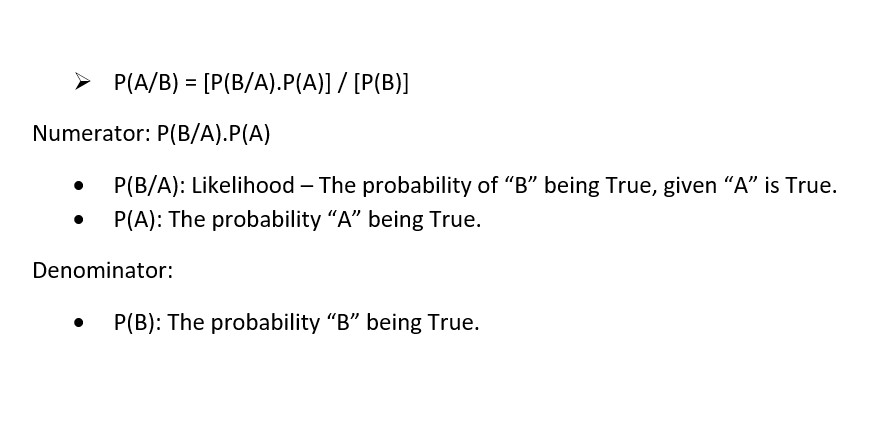

The independence of features and the absence of correlation between them serve as the foundation for the Naive Bayes algorithm. Furthermore, it makes the assumption that all features are equally significant and do not create redundancy.

When applying the Naive Bayes method, one problem that can occur is that the posterior probability might turn into zero when evaluating new data. For instance, the likelihood of a new word being encountered by a word finder model would be zero, yielding a final result of zero.

Laplace smoothing is applied to solve this problem. By modestly increasing the likelihood of unobserved events and decreasing the probability of observed events, this method assures that the posterior probability is never 0 and that the ultimate probability sum is always 1. To do this, the posterior probability formula is modified.

To deal with the problem of zero probability, Naive Bayes algorithms for text categorization employ Laplace smoothing, sometimes referred to as additive smoothing. By counting the instances of each word in the training data that correspond to that class, the term frequency-based Naive Bayes models calculate the likelihood that each word belongs to a given class.

The issue with this strategy is that there might be some test data terms that never appear in training data, leading the algorithm to give these words a chance of zero. This zero likelihood will translate into a zero likelihood in total for that class, resulting in an inaccurate categorization.

This problem is addressed by the Laplace smoothing method, which smoothes out the probability estimates and prevents any zero probabilities by adding a little positive constant (often 1) to each count. The constant's addition enables the algorithm to take into account additional terms and lessens the likelihood that the model will become overfit to the training set of data.

We modify the posterior probability formula in the following way:

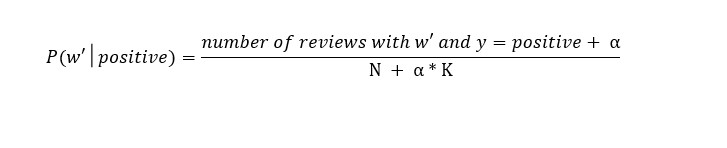

The value of alpha is a smoothing parameter, and if it is set to any value other than 0, the probability will no longer be zero.
Here, P(w' | positive) is the probability of word w' given the class positive. number of reviews with w' and y=positive is the count of the word w' in the positive class. N is the total number of words in the positive class. α is the smoothing constant, which is a small positive number (usually 1) used to prevent zero probabilities. K is the number of unique words in the vocabulary.

The formula computes the smoothed probability of a word w' belonging to the positive class by adding the smoothing constant α to the count of the word in the positive class, and then normalizing the result by dividing by the total number of words in the positive class plus the product of the smoothing constant and the number of unique words in the vocabulary.

Consider a simple example where we are trying to classify documents as either positive or negative based on the presence of certain words. We have a training set of 1000 positive and 1000 negative documents and the following word frequencies:

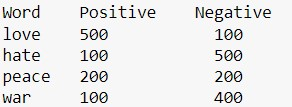

Without additive smoothing, we calculate the probability of each word given the positive and negative classes as follows:

P(love | positive) = 500/1000 = 0.5

P(hate | positive) = 100/1000 = 0.1

P(peace | positive) = 200/1000 = 0.2

P(war | positive) = 100/1000 = 0.1

P(love | negative) = 100/1000 = 0.1

P(hate | negative) = 500/1000 = 0.5

P(peace | negative) = 200/1000 = 0.2

P(war | negative) = 400/1000 = 0.4



Now, let's say we have a test document with the words "love" and "peace". We calculate the probability of the document being positive or negative as follows:

P(positive | {love, peace}) = P(positive) * P(love | positive) * P(peace | positive) = 0.5 * 0.5 * 0.2 = 0.05

P(negative | {love, peace}) = P(negative) * P(love | negative) * P(peace | negative) = 0.5 * 0.1 * 0.2 = 0.01



Since the probability of the document being positive is higher, we classify the document as positive.

However, in the case of a test document with the words "hate" and "war", we have:

P(positive | {hate, war}) = P(positive) * P(hate | positive) * P(war | positive) = 0.5 * 0.1 * 0.1 = 0.005

P(negative | {hate, war}) = P(negative) * P(hate | negative) * P(war | negative) = 0.5 * 0.5 * 0.4 = 0.1

Here, the probability of the document being negative is higher, so we classify the document as negative.


In this example, the absence of additive smoothing leads to incorrect classifications because the probabilities of certain words given a class are zero, causing the overall probability of the class to be zero as well. This issue can be addressed by using Laplace smoothing, where a small positive constant is added to each count to prevent zero probabilities.

### Part 2:


To categorize a document using the Naive Bayes technique, we must compute the product of many probabilities. For instance, when solving a text classification task, it may be necessary to add the probabilities of each word given a class in a document with many words. The product of the probabilities can, however, get very small as the document's word count rises and could cause floating-point arithmetic underflow issues.

When working with large vocabulary in a problem, the product of all probabilities tends to approach zero. This problem is made worse with each added feature, as multiplying many probabilities together results in a very small number. One solution to this issue is to represent probabilities as log-probabilities. This is done for several reasons:

Log-probabilities have a much wider range of numbers between -infinity and 0 compared to probabilities that are between 0 and 1.
The property of logarithms states that if a is less than b, then ln(a) is less than ln(b). Therefore, comparing log-probabilities is equivalent to comparing probabilities, which is necessary for determining the maximum probability (as in the argmax function).

A problem known as underflow arises when a number's magnitude is too small to be adequately represented in floating-point format. This reduces precision and increases the likelihood that the result will be rounded to zero, even if it is actually a small positive number.

To address this difficulty, we operate with logarithmic values instead of raw probabilities. Given that a number's logarithm is a monotonic function, if a > b, then log(a)  >  log (b). As a result, adding the logarithms of the individual numbers in a product is equivalent to adding the logarithms of the individual numbers. To overcome the issue of underflow, which happens when the product of numerous small probability values becomes too small to be represented by a computer, the Naive Bayes algorithm computes logarithmic values rather than just probability values. The difficulty is made worse by the addition of features since when working with a big vocabulary, the sum of all probabilities tends to be close to zero. This problem is solved by providing the probabilities as logarithmic numbers rather than conventional probability values. Because the sum of many small values gets turned into the product of many small values when computing logarithmic values. These values can be represented by the computer and are considerably easier to handle. Additionally, the range of numbers between -infinity and 0 is substantially greater for logarithmic values, allowing for more precise calculations.